In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from scipy.stats import spearmanr, zscore
from preprocessing import get_participant_names

# global variables
data_path = 'data/'
rank_result_path = 'rank-result/'

# get participant names
names = get_participant_names(data_path)
print('participants names: ', names)
print('participant num: ', len(names))

# generate rank
if not os.listdir(rank_result_path):
    from rank_utility import *
    # - click rank
    click_rank_files = [f for f in os.listdir(data_path) if "click_rank" in f]
    generate_click_rank(data_path, click_rank_files)
    # - general rank
    pairwise_rank_files = [f for f in os.listdir(data_path) if "pairwise_rank" in f]
    generate_pairwise_rank(data_path, pairwise_rank_files)

participants names:  ['hw', 'ts', 'jt', 'yz', 'lf', 'an', 'yx', 'yq', 'huy', 'hu', 'dao', 'mr', 'xiao', 'co', 'mh', 'lr']
participant num:  16


# Single Analysis

In [2]:
click_rank_data = pd.read_csv(rank_result_path + 'click_rank_result.csv')
pairwise_rank_data = pd.read_csv(rank_result_path + 'pairwise_rank_result.csv')
print(click_rank_data.dtypes, '\n')
print(pairwise_rank_data.dtypes)

tester               object
click_grid_1_rank    object
click_grid_2_rank    object
dtype: object 

tester             object
pwc_grid_1_rank    object
pwc_grid_1_2       object
pwc_grid_2_rank    object
pwc_grid_1_w       object
dtype: object


In [3]:
name = 'huy'

row = click_rank_data[click_rank_data['tester'] == name]
clk_1 = ast.literal_eval(row['click_grid_1_rank'].values[0])
clk_2 = ast.literal_eval(row['click_grid_2_rank'].values[0])

row = pairwise_rank_data[pairwise_rank_data['tester'] == name]
pw_1 = ast.literal_eval(row['pwc_grid_1_rank'].values[0])[0:-2]
pw_2 = ast.literal_eval(row['pwc_grid_2_rank'].values[0])[0:-2]

cor_1, pval_1 = spearmanr(clk_1, pw_1)
print(spearmanr(clk_1, pw_1))
print(spearmanr(pw_1, clk_1))
print(cor_1, pval_1)

SpearmanrResult(correlation=0.4285714285714286, pvalue=0.3965014577259474)
SpearmanrResult(correlation=0.4285714285714286, pvalue=0.3965014577259474)
0.4285714285714286 0.3965014577259474


In [4]:
# get orders of imgs
with open(data_path + name + '_click_rank.csv') as f:
        data = ast.literal_eval(f.readlines()[1])
# - take `name.jpg` from image path, and get into array
order_1 = [img_path.split('/')[-1] for img_path in data['1_order']]
order_2 = [img_path.split('/')[-1] for img_path in data['2_order']]

# get fixation distribution rank from gaze_analysis
dist_rank_data = pd.read_csv(rank_result_path + 'dist_rank.csv', dtype=str)
row = dist_rank_data[dist_rank_data['name'] == name]
# ranks are stored as [{'position in number': 'duration'}]
dist_1_dict = ast.literal_eval(row[row['event'] == 'gaze_grid_1']['rank'].values[0])
dist_2_dict = ast.literal_eval(row[row['event'] == 'gaze_grid_2']['rank'].values[0])
# convert to ['position in image name']
dist_1 = [order_1[list(f.keys())[0] - 1] for f in dist_1_dict]
dist_2 = [order_2[list(f.keys())[0] - 1] for f in dist_2_dict]


# Batch Analysis

In [5]:
click_rank_data = pd.read_csv(rank_result_path + 'click_rank_result.csv')
pairwise_rank_data = pd.read_csv(rank_result_path + 'pairwise_rank_result.csv')
dist_rank_data = pd.read_csv(rank_result_path + 'dist_rank.csv')
tick_fontsize = 12
label_fontsize = 14

## Correlation between Setwise Rank and Pairwise Rank

count    32.000000
mean      0.578571
std       0.409177
min      -0.200000
25%       0.257143
50%       0.685714
75%       0.942857
max       1.000000
dtype: float64 

no outlier


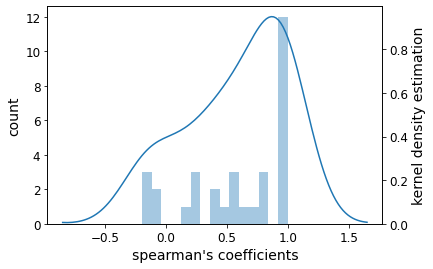

In [6]:
result = []

for name in names:
    row = click_rank_data[click_rank_data['tester'] == name]
    clk_1 = ast.literal_eval(row['click_grid_1_rank'].values[0])
    clk_2 = ast.literal_eval(row['click_grid_2_rank'].values[0])

    row = pairwise_rank_data[pairwise_rank_data['tester'] == name]
    pw_1 = ast.literal_eval(row['pwc_grid_1_rank'].values[0])[0:-2]
    pw_2 = ast.literal_eval(row['pwc_grid_2_rank'].values[0])[0:-2]

    row = dist_rank_data[dist_rank_data['name'] == name]
    dist_1 = ast.literal_eval(row[row['event'] == 'gaze_grid_1']['rank'].values[0])
    dist_2 = ast.literal_eval(row[row['event'] == 'gaze_grid_2']['rank'].values[0])
    
    cor_1, pval_1 = spearmanr(clk_1, pw_1)
    cor_2, pval_2 = spearmanr(clk_2, pw_2)
    
    result.append({'name': name,
                   'grid_1_cor': cor_1,
                   'grid_1_pval': pval_1,
                   'grid_2_cor': cor_2,
                   'grid_2_pval': pval_2,})

result = pd.DataFrame(result, columns=['name', 'grid_1_cor', 'grid_1_pval', 'grid_2_cor', 'grid_2_pval'])

c1 = result['grid_1_cor']
c2 = result['grid_2_cor']
cor = c1.append(c2, ignore_index=True)
plt.tick_params(labelsize=tick_fontsize)
ax = sns.distplot(cor, bins=15, kde=False)
plt.xlabel('spearman\'s coefficients', fontsize=label_fontsize)
plt.ylabel('count', fontsize=label_fontsize)
ax2 = ax.twinx()
plt.tick_params(labelsize=tick_fontsize)
sns.kdeplot(cor)
plt.ylabel('kernel density estimation', fontsize=label_fontsize)
plt.savefig('stats/sw-pw-comp', dpi=300)

print(cor.describe(), '\n')
if True not in (abs(zscore(cor)) >= 3): print('no outlier')
else: print('outlier detected')

## Correlation between Fixation Distribution Rank and Pairwise Rank

count    32.000000
mean     -0.019643
std       0.472799
min      -0.885714
25%      -0.385714
50%      -0.028571
75%       0.114286
max       1.000000
dtype: float64 

no outlier


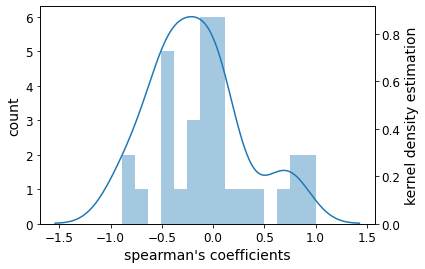

In [7]:
result = []

for name in names:
    row = pairwise_rank_data[pairwise_rank_data['tester'] == name]
    pw_1 = ast.literal_eval(row['pwc_grid_1_rank'].values[0])[0:-2]
    pw_2 = ast.literal_eval(row['pwc_grid_2_rank'].values[0])[0:-2]

    # get orders of imgs
    with open(data_path + name + '_click_rank.csv') as f:
            data = ast.literal_eval(f.readlines()[1])
    # - take `name.jpg` from image path, and get into array
    order_1 = [img_path.split('/')[-1] for img_path in data['1_order']]
    order_2 = [img_path.split('/')[-1] for img_path in data['2_order']]

    # get fixation distribution rank from gaze_analysis
    dist_rank_data = pd.read_csv(rank_result_path + 'dist_rank.csv', dtype=str)
    row = dist_rank_data[dist_rank_data['name'] == name]
    # ranks are stored as [{'position in number': 'duration'}]
    dist_1_dict = ast.literal_eval(row[row['event'] == 'gaze_grid_1']['rank'].values[0])
    dist_2_dict = ast.literal_eval(row[row['event'] == 'gaze_grid_2']['rank'].values[0])
    # convert to ['position in image name']
    dist_1 = [order_1[list(f.keys())[0] - 1] for f in dist_1_dict]
    dist_2 = [order_2[list(f.keys())[0] - 1] for f in dist_2_dict]
    
    cor_1, pval_1 = spearmanr(dist_1, pw_1)
    cor_2, pval_2 = spearmanr(dist_2, pw_2)
    
    result.append({'name': name,
                   'grid_1_cor': cor_1,
                   'grid_1_pval': pval_1,
                   'grid_2_cor': cor_2,
                   'grid_2_pval': pval_2,})

result = pd.DataFrame(result, columns=['name', 'grid_1_cor', 'grid_1_pval', 'grid_2_cor', 'grid_2_pval'])

c1 = result['grid_1_cor']
c2 = result['grid_2_cor']
cor = c1.append(c2, ignore_index=True)
ax = sns.distplot(cor, bins=15, kde=False)
plt.tick_params(labelsize=tick_fontsize)
plt.xlabel('spearman\'s coefficients', fontsize=label_fontsize)
plt.ylabel('count', fontsize=label_fontsize)
ax2 = ax.twinx()
sns.kdeplot(c2, ax=ax2, legend=False)
plt.tick_params(labelsize=tick_fontsize)
plt.ylabel('kernel density estimation', fontsize=label_fontsize)
plt.savefig('stats/fd-pw-comp', dpi=300)

print(cor.describe(), '\n')
if True not in (abs(zscore(cor)) >= 3): print('no outlier')
else: print('outlier detected')

## Correlation between Fixation Distribution and Setwise Ranking

count    32.000000
mean     -0.005357
std       0.509628
min      -0.942857
25%      -0.314286
50%       0.000000
75%       0.385714
max       0.942857
dtype: float64 

no outlier


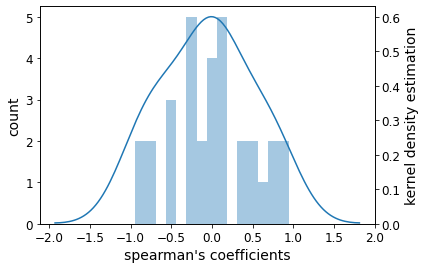

In [8]:
result = []

for name in names:

    row = click_rank_data[click_rank_data['tester'] == name]
    sw_1 = ast.literal_eval(row['click_grid_1_rank'].values[0])
    sw_2 = ast.literal_eval(row['click_grid_2_rank'].values[0])

    # get orders of imgs
    with open(data_path + name + '_click_rank.csv') as f:
            data = ast.literal_eval(f.readlines()[1])
    # - take `name.jpg` from image path, and get into array
    order_1 = [img_path.split('/')[-1] for img_path in data['1_order']]
    order_2 = [img_path.split('/')[-1] for img_path in data['2_order']]

    # get fixation distribution rank from gaze_analysis
    dist_rank_data = pd.read_csv(rank_result_path + 'dist_rank.csv', dtype=str)
    row = dist_rank_data[dist_rank_data['name'] == name]
    # ranks are stored as [{'position in number': 'duration'}]
    dist_1_dict = ast.literal_eval(row[row['event'] == 'gaze_grid_1']['rank'].values[0])
    dist_2_dict = ast.literal_eval(row[row['event'] == 'gaze_grid_2']['rank'].values[0])
    # convert to ['position in image name']
    dist_1 = [order_1[list(f.keys())[0] - 1] for f in dist_1_dict]
    dist_2 = [order_2[list(f.keys())[0] - 1] for f in dist_2_dict]
    
    cor_1, pval_1 = spearmanr(dist_1, sw_1)
    cor_2, pval_2 = spearmanr(dist_2, sw_2)
    
    result.append({'name': name,
                   'grid_1_cor': cor_1,
                   'grid_1_pval': pval_1,
                   'grid_2_cor': cor_2,
                   'grid_2_pval': pval_2,})

result = pd.DataFrame(result, columns=['name', 'grid_1_cor', 'grid_1_pval', 'grid_2_cor', 'grid_2_pval'])

c1 = result['grid_1_cor']
c2 = result['grid_2_cor']
cor = c1.append(c2, ignore_index=True)
ax = sns.distplot(cor, bins=15, kde=False)
plt.tick_params(labelsize=tick_fontsize)
plt.xlabel('spearman\'s coefficients', fontsize=label_fontsize)
plt.ylabel('count', fontsize=label_fontsize)
ax2 = ax.twinx()
sns.kdeplot(c2, ax=ax2, legend=False)
plt.tick_params(labelsize=tick_fontsize)
plt.ylabel('kernel density estimation', fontsize=label_fontsize)
plt.savefig('stats/fd-sw-comp', dpi=300)

print(cor.describe(), '\n')
if True not in (abs(zscore(cor)) >= 3): print('no outlier')
else: print('outlier detected')